# Analyse time-dependent proteome

## 1. Load data into workbook

In [1]:
import cPickle as pkl
import re
import random
import os.path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.nonparametric.smoothers_lowess import lowess

Write part of the directory listing to a variable:

In [2]:
import platform
if platform.system()=="Windows":
    files = !ls ..\results\po*
else:
    files = !ls ../results/po*

Set up a dictionary that contains the simulation results.

In [3]:
filepaths = {}
for file in files:
    match = re.search(r'from (\w+)', file)
    filepaths[int(match.group(1).zfill(4))] = file

Function to replace _numpypy.multiarray by numpy.core.multiarray. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [4]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

Port from Pypy to Python:

In [5]:
for time in filepaths:
    print time,
    replace(filepaths[time], "_numpypy.multiarray", "numpy.core.multiarray")

0 2400 3300 1800 300 2700 1200 600 2100 3000 900 1500


Create proteome dictionary:

In [6]:
results = {}
proteome = {}
for time in filepaths:
    print time,
    results[time] = pkl.load(open(filepaths[time]))
    proteome[time] = {key: results[time]['proteome'][key] for key in results[time]['proteome'] 
                     if results[time]['proteome'][key] > 1e-1}

0 2400 3300 1800 300 2700 1200 600 2100 3000 900 1500


## 2. Test whether burn-in period has been long enough

Plot timecourses:

In [23]:
time = 3300
protnames = results[time]['timecourses'].keys()
size = 5
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

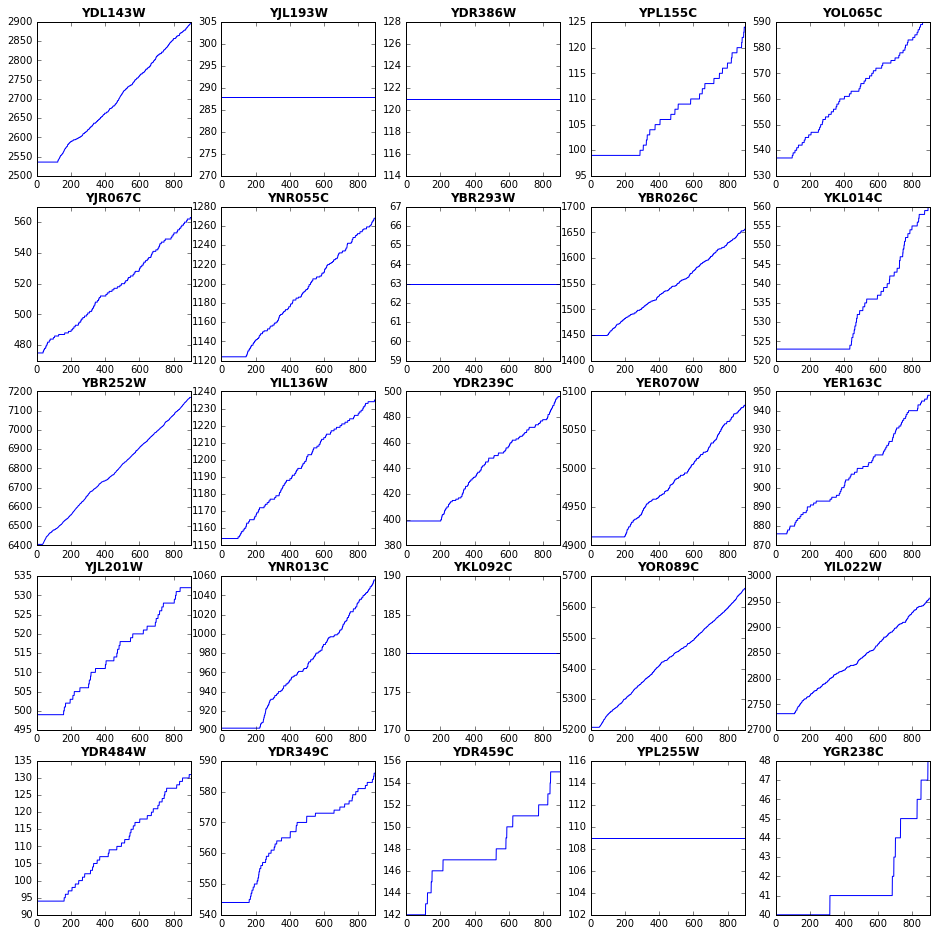

In [24]:
fig, ax = plt.subplots(size, size, figsize=(16, 16))

for i in range(size):
    for j in range(size):
        yseries = results[time]['timecourses'][protnames_plot[i][j]]
        xseries = np.arange(0., float(len(yseries)), 1.)
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 200.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=10)

Plot increases and check for saturation of "first derivative":

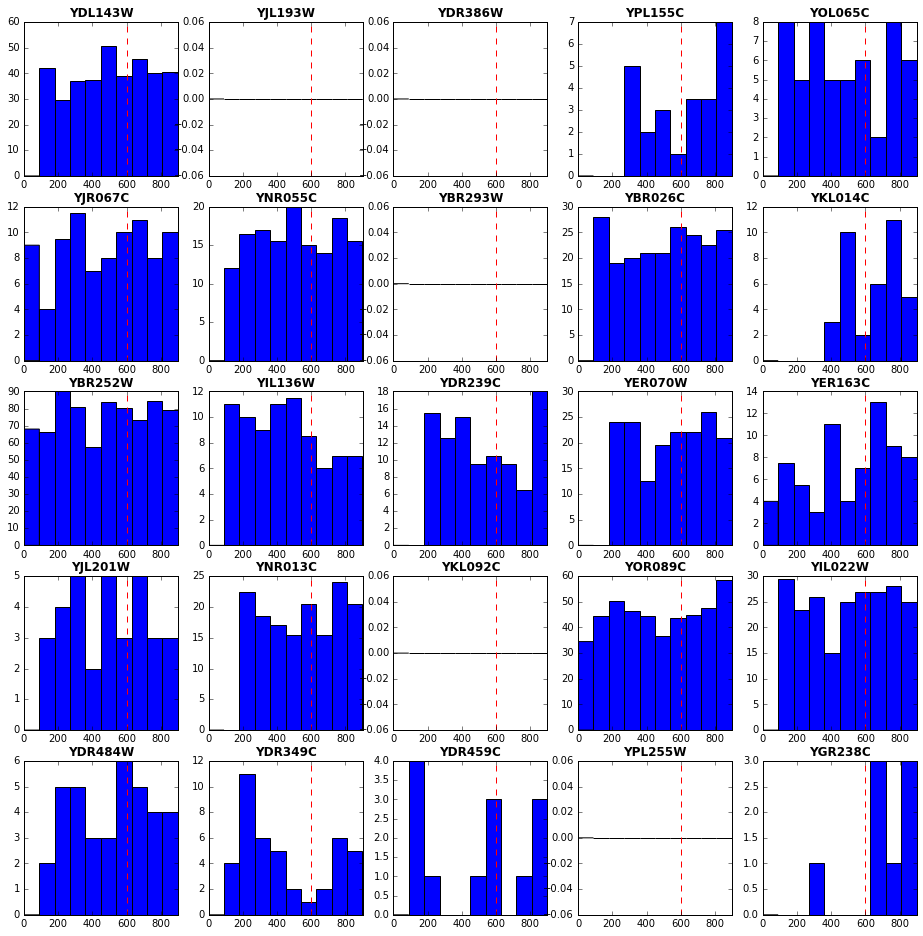

In [25]:
burnin = len(yseries) - 300  # 300 s simulation, rest is burn-in
fig, ax = plt.subplots(size, size, figsize=(16, 16))

for i in range(size):
    for j in range(size):
        yseries = results[time]['timecourses'][protnames_plot[i][j]]
        dy = np.gradient(yseries)
        xseries = np.arange(0., float(len(dy)), 1.)
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].hist(xseries, bins=10, weights=dy)
        ax[i, j].axvline(burnin, color='red', linestyle='--')
        ax[i, j].set_xticks(np.arange(min(xseries), max(xseries)+1, 200.0))
        ax[i, j].set_title(protnames_plot[i][j], fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax[i, j].tick_params(axis='both', which='major', labelsize=10)

## 3. Plot proteomes at different times

In [41]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None, fontsize=None):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    #fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
        if fontsize:
            ax.set_xlabel(xaxislabel, fontsize=fontsize)
            plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)
        if fontsize:
            ax.set_ylabel(yaxislabel, fontsize=fontsize)
            plt.setp(ax.get_yticklabels(), fontsize=fontsize)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(0.2)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    #plt.show()

3133


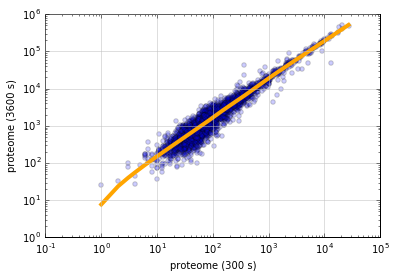

In [27]:
scatter_dicts(proteome[0], proteome[3300], xaxislabel="proteome (300 s)", yaxislabel="proteome (3600 s)", fontsize=None)

Prevent output from scrolling:

In [34]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

3133


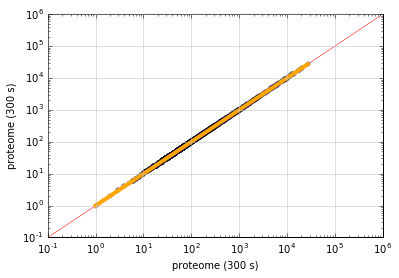

3133


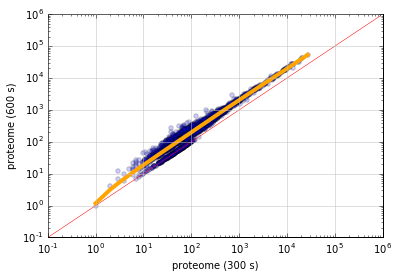

3133


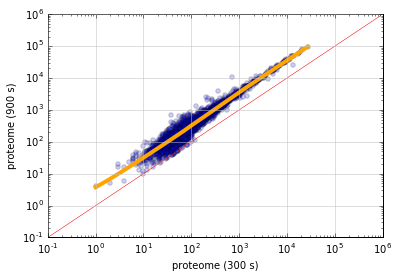

3133


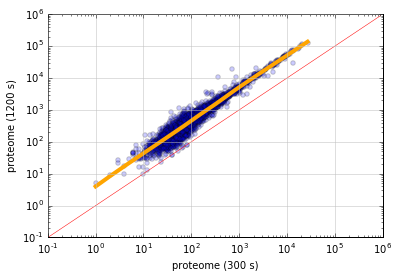

3133


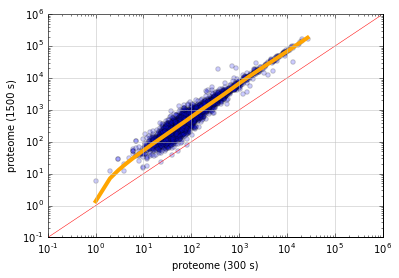

3133


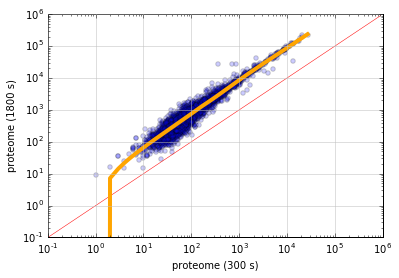

3133


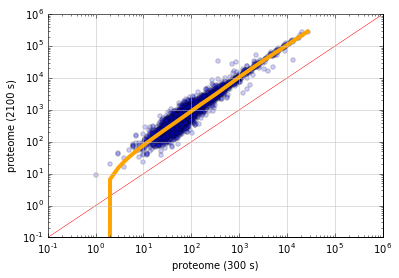

3133


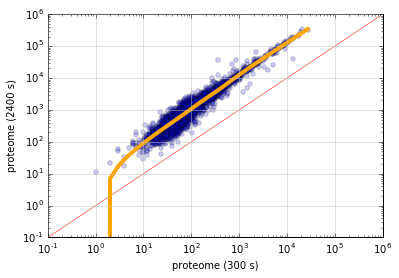

3133


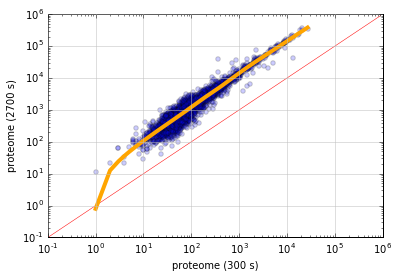

3133


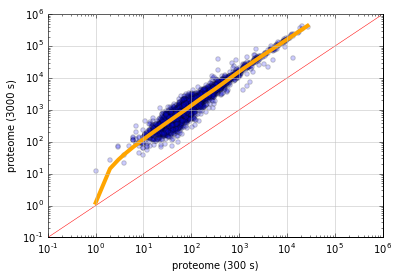

3133


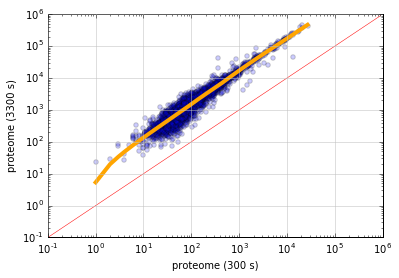

3133


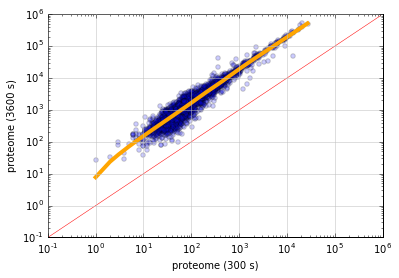

3133


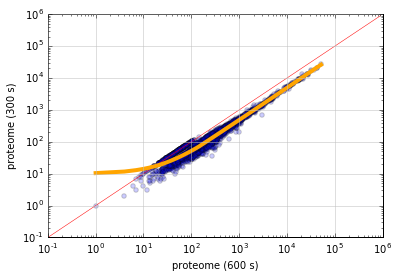

3489


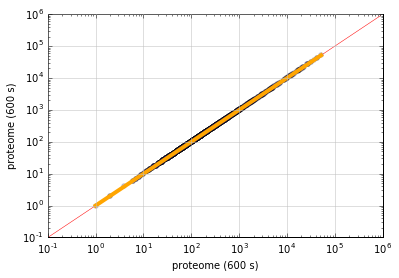

3489


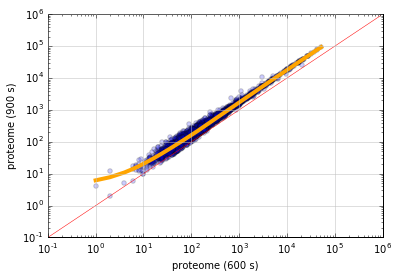

In [ ]:
times = np.arange(0, 3600, 300)
columns = 3
rows = len(times/columns)
for tx in times:
    #fig, ax = plt.subplots(rows, columns, figsize=(16, 16))
    for ty in times:
        fig =  plt.figure()                
        plt.plot([1e-1, 1e6-100000], [1e-1, 1e6-100000], color='red', linestyle='-', linewidth=0.5)
        scatter_dicts(proteome[tx], proteome[ty], xaxislabel="proteome ({} s)".format(tx+300), 
                      yaxislabel="proteome ({} s)".format(ty+300), fontsize=None)
        plt.show()